# Gradient Descent

- Initialize $\mathbf{w}(0)$
- For $t=0,1,2, \cdots \quad$ [to termination]
$$
\mathbf{w}(t+1)=\mathbf{w}(t)-\eta \nabla E_{\text {in }}(\mathbf{w}(t))
$$
- Return final w

With **Stochastic** gradient descent, we pick one $(x_n, y_n)$ at a time, applying Gradient Descent to $e(h(x_n), y_n)$.

Rule of thumb: $\eta = .1$ works.

# How the Network Operates

$$
w_{i j}^{(l)} \quad \begin{cases}1 \leq l \leq L & \text { layers } \\ 0 \leq i \leq d^{(l-1)} & \text { inputs } \\ 1 \leq j \leq d^{(l)} & \text { outputs }\end{cases}
$$

$$
\theta(s)=\tanh (s)=\frac{e^s-e^{-s}}{e^s+e^{-s}}
$$

$$
x_j^{(l)}=\theta\left(s_j^{(l)}\right)=\theta\left(\sum_{i=0}^{d^{(l-1)}} w_{i j}^{(l)} x_i^{(l-1)}\right)
$$

$$
\text { Apply } \mathbf{x} \text { to } x_1^{(0)} \cdots x_{d^{(0)}}^{(0)} \rightarrow \rightarrow x_1^{(L)}=h(\mathbf{x})
$$



# Applying SGD

Error on example $\left(\mathbf{x}_n, y_n\right)$ is
$$
\mathrm{e}\left(h\left(\mathbf{x}_n\right), y_n\right)=\mathrm{e}(\mathrm{w})
$$

To implement SGD, we need the gradient: 

$$
\nabla \mathrm{e}(\mathbf{w}): \frac{\partial \mathrm{e}(\mathrm{w})}{\partial w_{i j}^{(l)}} \text { for all } i, j, l
$$

# Computing $\frac{\partial \mathrm{e}(\mathbf{w})}{\partial w_{i j}^{(l)}}$

A trick for efficient computation:
$$
\frac{\partial \mathrm{e}(\mathbf{w})}{\partial w_{i j}^{(l)}}=\frac{\partial \mathrm{e}(\mathbf{w})}{\partial s_j^{(l)}} \times \frac{\partial s_j^{(l)}}{\partial w_{i j}^{(l)}}
$$

$$
\text { We have } \frac{\partial s_j^{(l)}}{\partial w_{i j}^{(l)}}=x_i^{(l-1)} \quad \text { We only need: } \frac{\partial \mathrm{e}(\mathrm{w})}{\partial s_j^{(l)}}=\delta_j^{(l)}
$$

# $\delta$ for the final layer

For the final layer $l=L$ and $j=1$
$$
\begin{aligned}
& \delta_1^{(L)}=\frac{\partial \mathrm{e}(\mathbf{w})}{\partial s_1^{(L)}} \\
& = \frac{\partial(\theta(s_1^{(L)}) - y_n)^2}{\partial s_1^{(L)}} \\
& = 2(\theta(s_1^{(L)}) - y_n)(\theta^{\prime}(s_1^{(L)})) \\
& = 2(x_1^{(L)} - y_n)(\theta^{\prime}(s_1^{(L)})) \\
& = 2(x_1^{(L)} - y_n)(1 - \theta^2(s_1^{(L)})) \\
& = 2(x_1^{(L)} - y_n)(1 - (x_1^{(L)})^2)
\end{aligned}
$$

# Back propagation of $\delta$

$$
\begin{aligned}
\delta_i^{(l-1)} & =\frac{\partial \mathrm{e}(\mathbf{w})}{\partial s_i^{(l-1)}} \\
& =\sum_{j=1}^{d^{(l)}} \frac{\partial \mathrm{e}(\mathbf{w})}{\partial s_j^{(l)}} \times \frac{\partial s_j^{(l)}}{\partial x_i^{(l-1)}} \times \frac{\partial x_i^{(l-1)}}{\partial s_i^{(l-1)}} \\
& =\sum_{j=1}^{d^{(l)}} \delta_j^{(l)} \times w_{i j}^{(l)} \times \theta^{\prime}\left(s_i^{(l-1)}\right) \\
\delta_i^{(l-1)} & =\left(1-\left(x_i^{(l-1)}\right)^2\right) \sum_{j=1}^{d^{(l)}} w_{i j}^{(l)} \delta_j^{(l)}
\end{aligned}
$$

![image.png](../images/network-architecture.png)

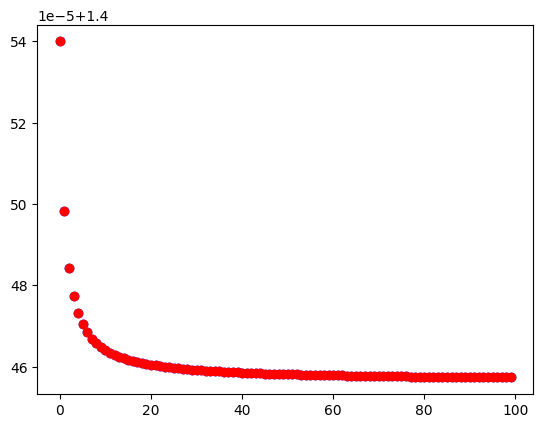

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# QSTN: reuse the same out of sample?  Or generate fresh like we've been doing?

class NeuralNetwork:
    TRAINING_INPUT_N = 10000
    TESTING_INPUT_N = 1000
    RNG = np.random.default_rng()
    ETA = .1
    # https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/
    # "an MLP with two hidden layers is sufficient for creating classification regions of any desired shape. This is instructive, although it should be noted that no indication of how many nodes to use in each layer"
    LAYER_STRUCTURE = [2, 3, 2, 1] # Two hidden layers, with 3 neurons and 2 neurons respectively.  Note that these counts do not include the bias neurons, which are indexed at 0.  See the structure in the image above.
    LAYER_COUNT = len(LAYER_STRUCTURE)
    ACTIVATION_FUNCTION = np.tanh
    EPOCH_LIMIT = 100

    def __init__(self):
        self.training_inputs = self.generate_inputs(self.TRAINING_INPUT_N)
        
        self.training_outputs = self.generate_outputs(self.training_inputs)
        
        # Initialize all neurons x with empty values
        self.x = self.initial_neurons()

        # Initialize all weights w_{ij}^(l) with Xavier weight initialization..
        self.weights = self.initial_weights()

        # Initialize the array of signal derivatives
        self.d = self.initial_signal_derivatives()

        # Keep track of e_ins and e_outs with these
        self.e_ins = np.empty(self.EPOCH_LIMIT)
        self.e_outs = np.empty(self.EPOCH_LIMIT)

    def generate_inputs(self, N):
        inputs = self.RNG.uniform(-1,1,(N, 2))
        return np.hstack((np.ones((N,1)), inputs)) # Set x_0 = 1 for all xs

    def generate_outputs(self, inputs):
        # Circle function (our target function):
        # If x_1^2 + x_2^2 < .5, then we are inside our circle (return +1) (which has radius of sqrt(.5) =~ .707).  else return -1.
        return np.sign(.5 - (np.square(inputs[:,1]) + np.square(inputs[:,2])))

    def initial_neurons(self):
        x = np.empty(self.LAYER_COUNT, dtype=object)

        for l, neuron_count in enumerate(self.LAYER_STRUCTURE):
            x[l] = np.empty(neuron_count + 1)
            if l < (len(self.LAYER_STRUCTURE) - 1):
                x[l][0] = 1 # 1 for bias
            else:
                x[l][0] = None # No bias on the final layer.  A placeholder to get 1-based indexing of real neurons.

        return x

    def initial_weights(self):
        # Note that our weights include biases.
        weights = np.empty(self.LAYER_COUNT, dtype=object)
        for l, neuron_count in enumerate(self.LAYER_STRUCTURE):
            if l == 0:
                prev_neuron_count = neuron_count
                continue # skip input layer
            weights[l] = np.empty((prev_neuron_count + 1, neuron_count + 1)) 
            weights[l][0,:] = 0.0 # initialize biases to 0
            for i in range(1, prev_neuron_count + 1):
                for j in range(1, neuron_count + 1):
                    weights[l][i][j] = self.xavier_weight(prev_neuron_count, neuron_count)
            prev_neuron_count = neuron_count
        
        return weights

    # looking like https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/, Xavier weight initialization is a good approach. 
    # Note: biases don't count towards count, so don't include them in the count.
    def xavier_weight(self, prev_neuron_count, neuron_count):
        return np.random.uniform(-np.sqrt(6)/np.sqrt(prev_neuron_count + neuron_count),np.sqrt(6)/np.sqrt(prev_neuron_count + neuron_count))

    def initial_signal_derivatives(self):
        d = np.empty(self.LAYER_COUNT, dtype=object)
        for l, neuron_count in enumerate(self.LAYER_STRUCTURE):
            if l == 0:
                continue # skip input layer
            d[l] = np.empty(neuron_count + 1)

        return d

    def sgd(self):
        epoch_count = 0 
        #TODO: ultimately, will want something like out of sample validation to end the loop
        while (epoch_count < self.EPOCH_LIMIT):
            # Generate a random permutation for how we pick the inputs
            input_perm = np.random.permutation(len(self.training_inputs))
            for input_id in input_perm:
                input = self.training_inputs[input_id]
                self.feed_forward(input)
                output = self.training_outputs[input_id]
                self.back_propogate(output)
                self.update_weights()
            
            # Report E_in and e_out for the epoch.

            avg_e_in = self.calculate_e_in()
            self.e_ins[epoch_count] = avg_e_in
            avg_e_out = self.calculate_e_out()
            self.e_outs[epoch_count] = avg_e_in

            epoch_count += 1
        
        # Show the plot of e_in and e_out by epoch
        figure, axis = plt.subplots(1, 2) 
        axis[0].scatter(range(0, self.EPOCH_LIMIT), self.e_ins, c='blue')
        axis[1].scatter(range(0, self.EPOCH_LIMIT), self.e_outs, c='red')
        plt.show()

    #QSTN: should feed_forward include setting of x?
    def feed_forward(self, input):
        # We compute all x_j^(l)
        # First we set layer 1 values
        self.x[0] = input

        for l in range(1, self.LAYER_COUNT):
            for j in range(1, len(self.x[l])):
                self.x[l][j] = self.ACTIVATION_FUNCTION(self.x[l - 1].dot(self.weights[l][:,j]))

    def back_propogate(self, output):
        # We compute all d_j^(l)
        # Begin by computing d_1^(L) for the final layer
        self.d[-1][1] = 2 * (self.x[-1][1] - output) * (1 - (self.x[-1][1] ** 2))

        # Now we loop through and calculate the previous d's backward..
        for l in reversed(range(1,self.LAYER_COUNT - 1)):
            for i in range(1, self.LAYER_STRUCTURE[l]):
                self.d[l][i] = (1 - ((self.x[l][i]) ** 2)) * self.weights[l+1][i][1:].dot(self.d[l + 1][1:])

    def update_weights(self):
        # Update the weights: w_{ij}^(l) = w_{ij}^(l) - (eta * x_i^(l-1) * d_j^(l))
        # We'd never have j= 1 as an output
        for l in range(1, self.LAYER_COUNT):
            for i in range(0, self.LAYER_STRUCTURE[l-1]):
                for j in range(1, self.LAYER_STRUCTURE[l]):
                    self.weights[l][i][j] = self.weights[l][i][j] - (self.ETA * self.x[l-1][i] * self.d[l][j])

    def calculate_e_in(self):
        total_e_in = 0

        for input_id, input in enumerate(self.training_inputs):
            self.feed_forward(input)
            
            h = self.x[-1][1]
            e_in = (h - self.training_outputs[input_id]) ** 2 # MSE measure
            total_e_in += e_in
        
        return total_e_in / len(self.training_inputs)

    def calculate_e_out(self):
        total_e_out = 0

        # QSTN: reuse the same out of sample?  Or generate fresh like we've been doing?
        testing_inputs = self.generate_inputs(self.TESTING_INPUT_N)
        testing_outputs = self.generate_outputs(testing_inputs)

        for testing_input_id, testing_input in enumerate(testing_inputs):
            self.feed_forward(testing_input)

            h = self.x[-1][1]
            e_out = (h - testing_outputs[testing_input_id]) ** 2 # MSE measure
            total_e_out += e_out

        return total_e_out / len(testing_inputs)

nn = NeuralNetwork()
nn.sgd()